In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm import tqdm
import pathlib


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision.transforms as T

#sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io

################# DETR FUCNTIONS FOR LOSS #######################
import sys
sys.path.append('./detr_custom/')

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
import engine
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

from typing import Iterable, Sequence, List, Tuple, Dict, Optional, Union, Any, Callable
from types import ModuleType
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from generators import BlenderStandardDataset, TorchStandardDataset
import importlib
from pprint import pprint
import sqlite3 as db
from functools import wraps

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
def pytorch_init_janus_gpu():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Unexpected GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)


def reloader(module_or_member: Union[ModuleType, Any]):    
    if isinstance(module_or_member, ModuleType):
        importlib.reload(module_or_member)
        return module
    else:
        module = importlib.import_module(module_or_member.__module__)
        importlib.reload(module)
        return module.__dict__[module_or_member.__name__]

In [3]:
seed = 42069
seed_everything(seed)

try:
    device = pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [4]:
TORCH_CACHE_DIR = 'torch_cache'
DATASET_DIR = '/mnt/blendervol/objdet_std_data'
SQL_TABLE = 'bboxes_std'
WEIGHTS_DIR = 'fish_statedicts'
NUM_CLASSES=6+1

In [5]:
db_con = db.connect(f'file:{os.path.join(DATASET_DIR,"bboxes.db")}?mode=ro', uri=True)

In [6]:
n_data = pd.read_sql_query('SELECT COUNT(DISTINCT(imgnr)) FROM bboxes_std', db_con).values[0][0]

TRAIN_RANGE = (0, int(3/4*n_data))
VAL_RANGE = (int(3/4*n_data), n_data)

In [7]:
torch.hub.set_dir(TORCH_CACHE_DIR)

<!--  
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load(
            os.path.join(TORCH_CACHE_DIR, 'facebookresearch_detr_master'), 
            model='detr_resnet50', 
            pretrained=True,
            source='local'
        )
        
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

model = DETRModel(NUM_CLASSES, 100)
model = model.to(device)
-->

In [15]:
def save_model(obj: Any, f: str):
    pathlib.Path(f).parent.mkdir(parents=True, exist_ok=True)
    assert isinstance(f, str), "Filename must be of type string when saving model"
    torch.save(obj=obj, f=f)
    
    
def interruptable(f: Callable):
    '''Decorator for functions that should handle KeyboardInterrupts more gracefully'''
    @wraps(f)
    def wrapper(*args, **kwargs):
        try:
            retval = f(*args, **kwargs)
        except KeyboardInterrupt as e:
            print('Process interrupted')
            return 
        return retval
    return wrapper


def _validate_model(context, traintqdminfo):
    running_val_loss = 0.0

    # valbar will disappear after it is done since leave=False
    valbar = tqdm(
        iterable=enumerate(context['valloader'], 0), 
        total=len(context['valloader']), 
        unit=' batches',
        desc=f' Validating',
        ascii=True,
        position=0,
        leave=False
    )
    
    model = context['model']
    criterion = context['criterion']
    
    model.eval()
    criterion.eval()

    # Loop through val batches
    with torch.no_grad():
        for i, (images, labels) in valbar:
            images = [image.to(device) for image in images]
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

            output = model(images)

            loss_dict = criterion(output, labels)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            # print statistics
            running_val_loss += losses.item()
            val_loss = running_val_loss / (i+1)
            valtqdminfo = {**traintqdminfo, 'val loss':val_loss}
            valbar.set_postfix(valtqdminfo)
            
    return valtqdminfo


def _train_model(context, epoch, n_epochs):
    running_train_loss = 0.0

    trainbar = tqdm(
        iterable=enumerate(context['trainloader'], 0),
        total=len(context['trainloader']),
        unit=' batches',
        desc=f' Epoch {epoch+1}/{n_epochs}',
        ascii=True,
        position=0,
        leave=False
    )

    model.train()
    criterion.train()

    # Loop through train batches
    for i, (images, labels) in trainbar:
        images = [image.to(device) for image in images]
        labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

        output = model(images)
        loss_dict = criterion(output, labels)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # Zero parameter gradients since PyTorch will just accumulate the gradient
        # vectors while it trains (in order to get the "mean" direction to move in
        # the parameter space). Also doing it this way minimizes memory allocation
        # etc, probably.
        optimizer.zero_grad()

        losses.backward() # Computes gradients
        optimizer.step() # Do a gradient step

        # print statistics
        running_train_loss += losses.item()
        train_loss = running_train_loss / (i+1)
        traintqdminfo = {'train loss':train_loss}
        trainbar.set_postfix(traintqdminfo)
    
    return trainbar, traintqdminfo


@interruptable
def train_model(
        trainloader: DataLoader, 
        valloader: DataLoader, 
        model: nn.Module, 
        criterion, 
        optimizer, 
        n_epochs: int, 
        device: torch.device, 
        validate: bool = True,
        save_best: bool = True
    ):
    
    # for convenience
    context = {
        'trainloader':trainloader,
        'valloader':valloader,
        'model':model,
        'criterion':criterion,
        'optimizer':optimizer,
        'device':device
    }
    
    best_val_loss = np.inf
    
    for epoch in range(n_epochs):
        trainbar, traintqdminfo = _train_model(context, epoch, n_epochs)
            
        if validate:
            valtqdminfo = _validate_model(context, traintqdminfo)
        
            # Extra dirty tqdm hack hehe
            # _validate_model will create its own tqdm bar that will replace the bar
            # from _train_model, but will clear itself afterwards
            # the code below reactivates the previous train bar
            trainbar.disable = False
            trainbar.set_postfix({**traintqdminfo, **valtqdminfo})
            trainbar.disable = True
            print(file=sys.stderr)
        
            # Save best models
            if save_best:
                if valtqdminfo['val loss'] < best_val_loss:
                    best_val_loss = valtqdminfo['val loss']
                    isodatenow = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
                    daydir = datetime.today().strftime("weights_%Y-%m-%d")
                    filename = (
                        f'detr_statedicts_epoch{epoch+1}'
                        f'_train{traintqdminfo["train loss"]:.4f}_val{best_val_loss:.4f}'
                        f'_{isodatenow}.pth'
                    )
                    filepath = os.path.join(WEIGHTS_DIR, daydir, filename)

                    save_model(
                        obj={
                            'model':model.state_dict(),
                            'optimizer':optimizer.state_dict(),
                            'criterion':criterion.state_dict(),
                        },
                        f = filepath
                    )
        
            

In [9]:
from torchvision.models import resnet50
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        
        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        
        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        if not isinstance(inputs, torch.Tensor):
            inputs = torch.stack(inputs, dim=0).to(device)

        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    
        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
    
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

def prepare_model(model, num_classes):
    state_dict = torch.hub.load_state_dict_from_url(
        url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
        map_location='cpu',
        check_hash=True
    )
    
    model.load_state_dict(state_dict)
    model.linear_class = nn.Linear(model.linear_bbox.in_features, num_classes + 1)
    return model
    
model = DETRdemo(91)
model = prepare_model(model, 6)
model = model.to(device)

In [17]:
weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']
matcher = HungarianMatcher()
criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = 0.5, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=8e-5, momentum=0.001, dampening=0.000001)

BATCH_SIZE = 1
traingen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False, imgnrs=range(0,512))
valgen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False, imgnrs=range(1024,1024+256))

trainloader = DataLoader(
    dataset=traingen,
    batch_size=1,
    collate_fn=lambda x: tuple(zip(*x)),
)

valloader = DataLoader(
    dataset=valgen,
    batch_size=1,
    collate_fn=lambda x: tuple(zip(*x)),
)


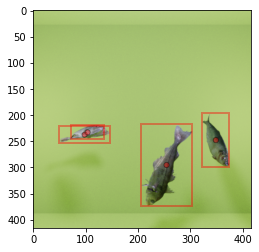

In [11]:
def sanity_dataset(gen: DataLoader, index=0):
    geniter = iter(gen)
    
    for i in range(index+1):
        img, targets = next(geniter)
    
    img = img.numpy().transpose((1,2,0))
    boxes = targets['boxes'].numpy()
    
    h, w = img.shape[:2]
    
    ax = plt.gca()
    ax.imshow(img)
    
    for box in boxes:
        cxy = box[:2]
        # Visualize center xy
        ax.add_patch(plt.Circle(cxy*(h, w), 5, facecolor='red', edgecolor='k', alpha=0.4))
        
        bw, bh = box[2], box[3]
        # tlxy = top left xy
        tlxy = (cxy - (bw/2, bh/2))*(h, w)
        ax.add_patch(plt.Rectangle(tlxy, bw*w, bh*h, fill=False, lw=2, color='red', alpha=0.4))

sanity_dataset(traingen, 0)

In [18]:
train_model(
    trainloader,
    valloader,
    model,
    criterion,
    optimizer,
    n_epochs=20000,
    device=device,
    save_best=True
)

 Epoch 76/20000: 100%|##########| 512/512 [01:05<00:00,  8.91 batches/s, train loss=0.261, val loss=0.402]


 Epoch 152/20000: 100%|##########| 512/512 [01:05<00:00,  8.78 batches/s, train loss=0.215, val loss=0.389]


 Epoch 164/20000: 100%|##########| 512/512 [01:05<00:00,  8.97 batches/s, train loss=0.213, val loss=0.382]
                                                                                           

Process interrupted


In [ ]:
def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def plot_results(img: Image.Image, classes: Iterable, boxes: Iterable):
    fig, ax = plt.subplots(figsize=(16,10))
    plt.imshow(img)
    
    if len(boxes) != 0:
        h, w = img.shape[:2]
        boxes = box_cxcywh_to_xyxy(boxes)
        boxes[:,[0,2]] *= w
        boxes[:,[1,3]] *= h

        for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='cyan', linewidth=3))
            try:
                ax.text(xmin, ymin, CLASSES[cls], fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
            except:
                pass
            
    plt.axis('off')
    plt.show()

    
def postprocess(logits: torch.Tensor, boxes: torch.Tensor):
#     return logits.argmax(-1), boxes
    keepmask = logits.softmax(-1)[:,:-1].max(-1)[0] > 0.2
    if any(keepmask) == False:
        return torch.Tensor(), torch.Tensor()
    return logits[keepmask].argmax(-1), boxes[keepmask]

    
def eval_model(model, img: torch.Tensor):    
    with torch.no_grad():
        model.eval()
        
        output = model(img.to(device).unsqueeze(0))
        
        boxes = output['pred_boxes'][0]
        logits = output['pred_logits'][0]
        print(logits.argmax(-1))
        
        logits_, boxes_ = postprocess(logits, boxes)
        
        plot_results(img.cpu().numpy().transpose((1,2,0)), logits_, boxes_)
        
        
def eval_model2(model: nn.Module, img: Image.Image): 
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    img_torch = transform(img).to(device)
    
    model.eval()
    with torch.no_grad():    
        output = model(img_torch.unsqueeze(0))
        
    boxes = output['pred_boxes'][0]
    logits = output['pred_logits'][0]
    logits_, boxes_ = postprocess(logits, boxes)
    
    
    plot_results(np.array(img), logits_, boxes_)
    
    
x, y = valgen[104]
eval_model(model, x)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 5, 6, 6,
        6, 6, 6, 6], device='cuda:1')


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [ ]:
raise ValueError

In [ ]:
# test_img = io.imread('test_image2.png').copy() / 255
test_img = Image.open('test_image1.jpg').convert('RGB')

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_img_torch = transform(test_img)
test_img_torch